In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')

import os
len(os.listdir('drive/MyDrive/Data/'))

from tensorflow.keras.preprocessing import image_dataset_from_directory

img_size = 150
image_size = (img_size, img_size)

batch_size = 5

training_set = image_dataset_from_directory(
    'drive/MyDrive/Data/',
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1303,
    image_size=image_size,
    batch_size=batch_size,
)

validation_set =image_dataset_from_directory(
    'drive/MyDrive/Data/',
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1303,
    image_size=image_size,
    batch_size=batch_size,
)

test_set =image_dataset_from_directory(
    'drive/MyDrive/Data/',
    labels = "inferred",
    label_mode = 'int',
    seed=1303,
    image_size=image_size,
    batch_size=545,
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 545 files belonging to 2 classes.
Using 436 files for training.
Found 545 files belonging to 2 classes.
Using 109 files for validation.
Found 545 files belonging to 2 classes.


In [ ]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x_train = np.array([])
for x, y in training_set:
  x_train = np.concatenate([x])
  
x_test = np.array([])
for x, y in validation_set:
  x_test = np.concatenate([x])
  y_test = np.concatenate([y])

x_test_test = np.array([])
for x, y in test_set:
  x_test_test = np.concatenate([x])
  y_test_test = np.concatenate([y])

['Shady', 'Thomas']


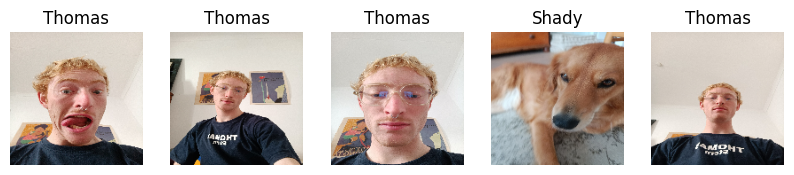

In [ ]:
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(batch_size):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### **Create the network**

In [ ]:
# Define input shape and latent dimension
latent_dim = 2
input_shape = (img_size, img_size, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)

#magnitude
z_mean_1 = Dense(latent_dim)(x)
z_log_var_1 = Dense(latent_dim)(x)

#phase
#z_mean_p = Dense(latent_dim)(x)
#z_log_var_p = Dense(latent_dim)(x)
z_mean_2 = Dense(latent_dim)(x)
z_log_var_2 = Dense(latent_dim)(x)

In [ ]:
from tensorflow.python.eager.context import anonymous_name
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z1 = Lambda(sampling)([z_mean_1, z_log_var_1])

# Reparameterization trick
#z2 = Lambda(sampling_p)([z_mean_p, z_log_var_p])
z2 = Lambda(sampling)([z_mean_2, z_log_var_2])


def complexreal(args):
    mag, phase = args
    x = mag*K.cos(phase)
    return x

def complexi(args):
    mag, phase = args
    y = mag*K.sin(phase)
    return y

z_complex_real = Lambda(complexreal)([z1,z2])
z_complex_i = Lambda(complexi)([z1,z2])
z_complex_concat = tf.keras.layers.Concatenate()([z_complex_real, z_complex_i])

# Define the VAE model
encoder = Model(inputs, [z_complex_real, z_complex_i, z_complex_concat], name='encoder')
#encoder.summary()


Decoder

In [ ]:
# Decoder network
decoder_input = Input(K.int_shape(z_complex_concat)[1:])
#decoder_input = Input(K.int_shape(z1)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


Model

In [ ]:
# Define the VAE model
encoder = Model(inputs, [z_complex_real, z_complex_i, z_complex_concat], name='encoder')
#encoder = Model(inputs, [z1, z_mean_m, z_log_var_m], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
#encoder.summary()
#decoder.summary()

Loss function

In [ ]:
def kl_divergence_uniform(q):
    return K.sum(K.square(q - 0.5), axis=1)

# Define the VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss_1 = -0.5 * K.sum(1 + z_log_var_1 - K.square(z_mean_1) - K.exp(z_log_var_1), axis=1)
kl_loss_2 = -0.5 * K.sum(1 + z_log_var_2 - K.square(z_mean_2) - K.exp(z_log_var_2), axis=1)
B = 1000
vae_loss = K.mean(B * reconstruction_loss + kl_loss_1 + kl_loss_2)
vae.add_loss(vae_loss)

vae.add_metric(kl_loss_1, name="kl_loss_1")
vae.add_metric(kl_loss_2, name="kl_loss_2")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")

Training

In [ ]:
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=1000, batch_size=batch_size, validation_data=(x_test,None))

Observing the latent space

18/18 [==============================] - 1s 28ms/step


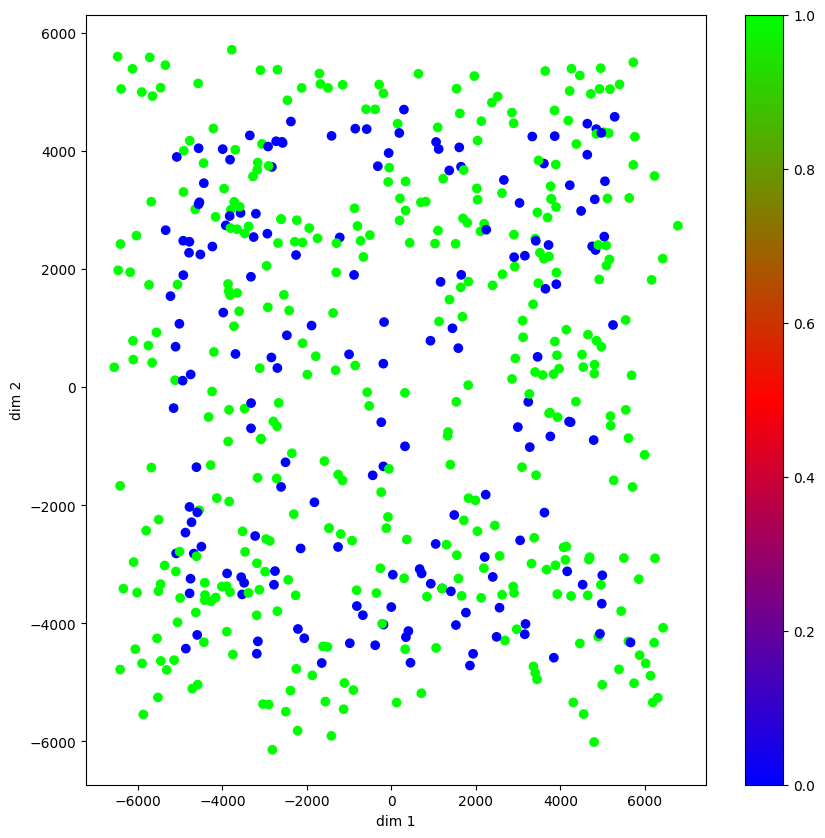

In [ ]:
z_complex_real_out, z_complex_i_out, z_complex_concat_out = encoder.predict(x_test_test)
plt.figure(figsize=(10, 10))
plt.scatter(z_complex_real_out[:, 0], z_complex_real_out[:, 1], c=y_test_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

18/18 [==============================] - 0s 24ms/step


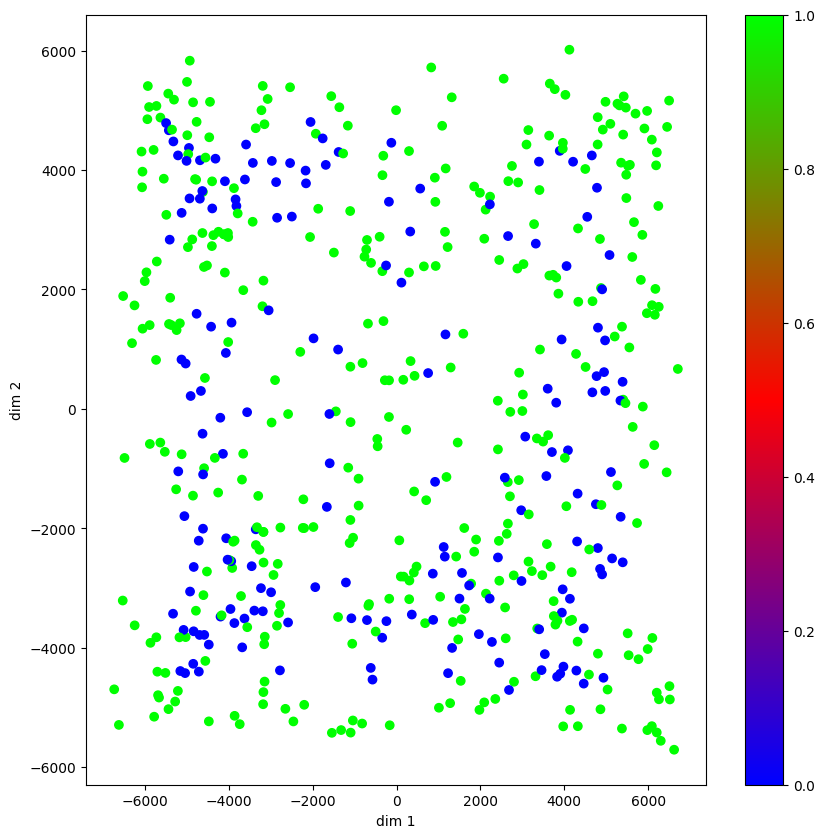

In [ ]:
z_complex_real_out, z_complex_i_out, z_complex_concat_out = encoder.predict(x_test_test)
plt.figure(figsize=(10, 10))
plt.scatter(z_complex_i_out[:, 0], z_complex_i_out[:, 1], c=y_test_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Convert the predictions into images
num_samples = 10
random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))

decoded_imgs = vae.predict(random_latent_vectors)
# Display the original and reconstructed images
n = 1 # number of images to display
plt.figure(figsize=(10, 10))

1/1 [==============================] - 0s 335ms/step


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

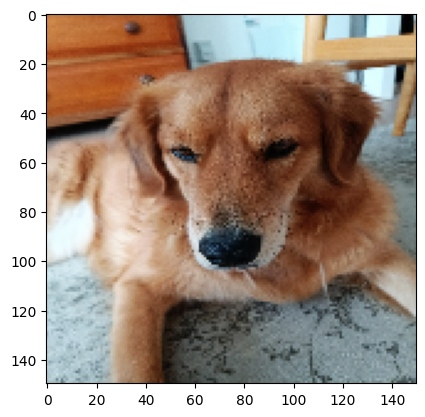

In [ ]:
i = 2
plt.imshow(random_latent_vectors[i].reshape(img_size, img_size,3))
plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
plt.show()

In [ ]:
n = 7
figure = np.zeros((img_size * n, img_size * n, 3))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space

start = -6000
stop = 6000

grid_x = np.linspace(start, stop, n)
grid_y = np.linspace(start, stop, n)[::-1]

print(grid_x)
print(grid_y)

testing = np.array([])

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi,xi,yi]])
        x_decoded = decoder.predict(z_sample)
        if (i==0) & (j==0):
          testing = np.concatenate([x_decoded])
        else:
          temp = np.concatenate([x_decoded])
          testing = np.concatenate((testing,temp))

print(testing.shape)

[-6000. -4000. -2000.     0.  2000.  4000.  6000.]
[ 6000.  4000.  2000.     0. -2000. -4000. -6000.]
1/1 [==============================] - 0s 20ms/step
(49, 150, 150, 3)


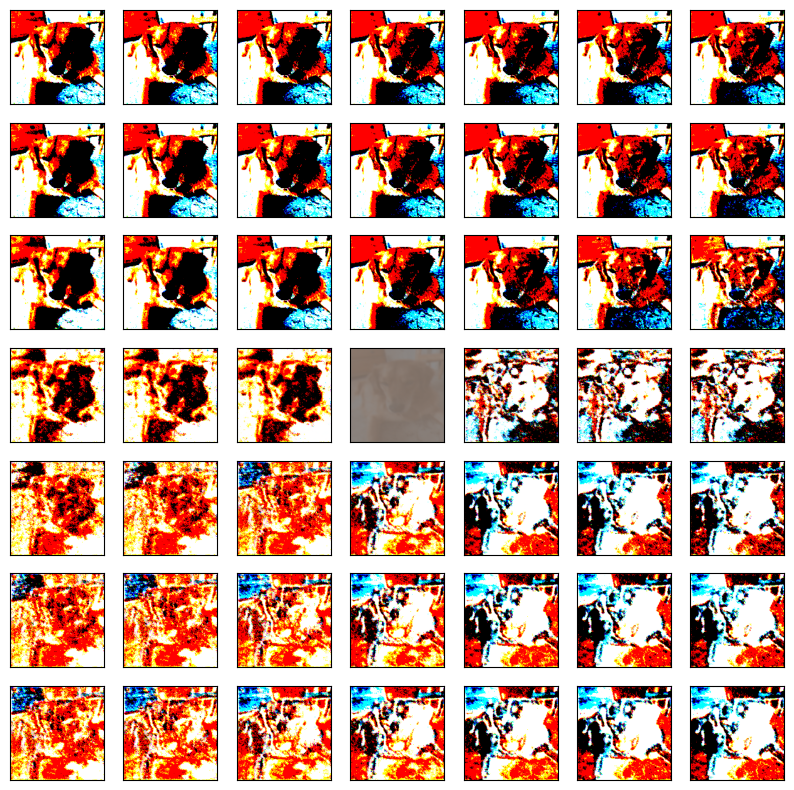

In [ ]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

n =  n*n
plt.figure(figsize=(10, 10))


for i in range(49):
    # Display the original image
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(testing[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()

1/1 [==============================] - 0s 64ms/step


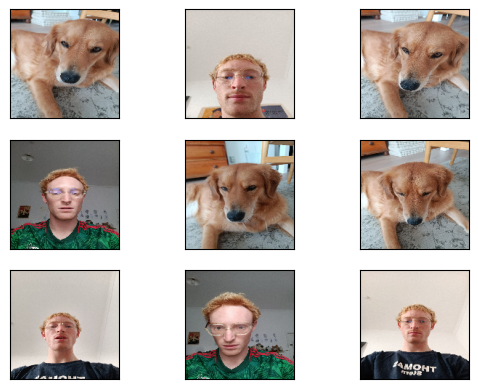

In [ ]:
x = x_test_test[10:20]
lesttest = vae.predict(x)
for i in range(9):
    # Display the original image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].reshape(img_size, img_size,3).astype('uint8'))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

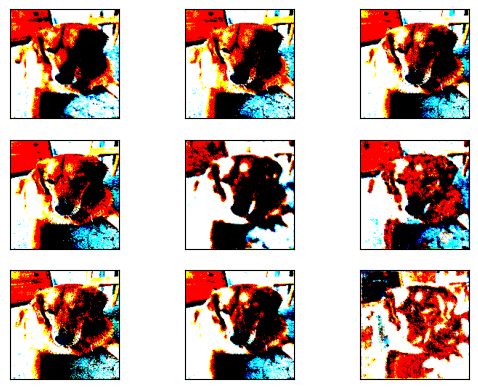

In [ ]:
for i in range(9):
    # Display the original image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lesttest[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)